In [1]:
import pandas as pd
import json

from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer


file_path = '/home/fjiriges/CodeXGLUE/Code-Code/Defect-detection/dataset/test.jsonl'

examples = [] 
labels = [] 
with open(file_path) as f:
            for line in f:
                js=json.loads(line.strip())
                examples.append(' '.join(js['func'].split()))
                labels.append(js['target'])

In [2]:
index = 6
code_example = examples[index]
label = labels[index]


In [3]:
import torch
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)

We load pre-trained model and tokenizers

In [4]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
model_path = "microsoft/codebert-base"

#load model
model = RobertaForSequenceClassification.from_pretrained(model_path, output_attentions=True)
# model.to(device)
model.eval()
model.zero_grad()
# load tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_path)

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be 

In [ ]:
# A helper function to perform fowad pass and get the attention weights
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, 
                   token_type_ids=token_type_ids,
                   position_ids = position_ids,
                   attention_mask = attention_mask)
    
    return output.logits, output.attentions

In [5]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

ref_token_id, sep_token_id, cls_token_id

(1, 2, 0)

Below we define a set of helper function for constructing references / baselines for word tokens, token types and position ids.

In [6]:
def construct_input_ref_pair(code_snippet, ref_token_id, sep_token_id, cls_token_id):
    code_ids = tokenizer.encode(code_snippet, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + code_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(code_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(code_ids)


In [7]:
def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

In [8]:
def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    
    return position_ids, ref_position_ids

In [9]:
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

In [10]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(code_example, ref_token_id, sep_token_id, cls_token_id)

token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)

position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)

attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

# Start

In [1]:
import torch
from model import Model
from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          BertConfig, BertForMaskedLM, BertTokenizer,
                          GPT2Config, GPT2LMHeadModel, GPT2Tokenizer,
                          OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer,
                          DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)

device = torch.device("cpu")

model_name_or_path = "microsoft/codebert-base"

MODEL_CLASSES = {
    'gpt2': (GPT2Config, GPT2LMHeadModel, GPT2Tokenizer),
    'openai-gpt': (OpenAIGPTConfig, OpenAIGPTLMHeadModel, OpenAIGPTTokenizer),
    'bert': (BertConfig, BertForMaskedLM, BertTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer),
    'distilbert': (DistilBertConfig, DistilBertForMaskedLM, DistilBertTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES['roberta'] 

config = RobertaConfig.from_pretrained(model_name_or_path, cache_dir=None, output_attentions=True)

config.num_labels=1
tokenizer = RobertaTokenizer.from_pretrained(model_name_or_path,
                                            do_lower_case=False,
                                            cache_dir=None)
block_size = 20


In [2]:
model = RobertaForSequenceClassification(config)
model=Model(model, config, tokenizer, None)
# load checkpoints 
checkpoint_prefix = "./saved_models/checkpoint-best-acc/model.bin"
model.load_state_dict(torch.load(checkpoint_prefix)) 
model = model.to(device)

In [3]:
class InputFeatures(object):
    """A single training/test features for a example."""
    def __init__(self,
                 input_tokens,
                 input_ids,
                 idx,
                 label):
        self.input_tokens = input_tokens
        self.input_ids = input_ids
        self.idx=str(idx)
        self.label=label
        
def convert_examples_to_features(js, tokenizer, block_size=512):
    #source
    code=' '.join(js['func'].split())
    code_tokens=tokenizer.tokenize(code)[:block_size-2]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    padding_length = block_size - len(source_ids)
    source_ids+=[tokenizer.pad_token_id]*padding_length
    
    return InputFeatures(source_tokens,source_ids,js['idx'],js['target'])

In [4]:
js = {'func': 'def max(a,b): if a>b: return a else: return b', 'idx': 0, 'target': 0}

code_example = convert_examples_to_features(js, tokenizer, block_size=block_size)

input_ids = torch.tensor([code_example.input_ids])
input_labels = torch.tensor([code_example.label])
input_tokens = code_example.input_tokens
attention_mask=input_ids.ne(1)

In [5]:
lm_loss, logit, output_attentions = model(input_ids=input_ids, 
                                          attention_mask=attention_mask,
                                          labels=input_labels)
pred = logit.item()
pred_ind = round(pred)

print(lm_loss, logit)
print(pred, pred_ind)

tensor(1.2787, grad_fn=<NegBackward0>) tensor([[0.7216]], grad_fn=<SigmoidBackward0>)
0.7215940952301025 1


In [6]:
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

# generate reference indices for each sample
token_reference = TokenReferenceBase(reference_token_idx=ref_token_id) # use padding_idx for roberta
seq_length = len(code_example.input_ids)
reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

In [16]:
def predic_forward_func(inputs):
    logit = model(inputs_embeds=inputs)
    print(logit)
    print(type(logit))
    # pred = logit.item()
    # pred_ind = round(pred)
    return logit

In [18]:
lig = LayerIntegratedGradients(model, model.encoder.roberta.embeddings)

In [19]:
 # compute attributions and approximation delta using layer integrated gradients
attributions_ig, delta = lig.attribute(input_ids, 
                                       reference_indices,
                                       return_convergence_delta=True)

In [20]:
attributions = attributions_ig.sum(dim=2).squeeze(0)
attributions = attributions / torch.norm(attributions)
attributions = attributions.cpu().detach().numpy()

In [21]:
vis_data_records_ig = []

vis_data_records_ig.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred,
                            pred_ind,
                            input_labels,
                            "Pos",
                            attributions.sum(),
                            code_example.input_tokens,
                            delta))

In [22]:
print('Visualize attributions based on Integrated Gradients')
_ = visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
tensor([0]),1 (0.77),Pos,1.25,"#s def Ġmax ( a , b ): Ġif Ġa > b : Ġreturn Ġa Ġelse : Ġreturn Ġb #/s"


In [23]:
# shape -> layer x batch x head x seq_len x seq_len 
output_attentions_all = torch.stack(output_attentions)
output_attentions_all.shape

torch.Size([12, 1, 12, 20, 20])

In [24]:
import numpy as np
from matplotlib import pyplot as plt

def visualize_token2token_scores(scores_mat, x_label_name='Head'):
    fig = plt.figure(figsize=(20, 20))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(4, 3, idx+1)
        # append the attention weights
        im = ax.imshow(scores, cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(input_tokens)))
        ax.set_yticks(range(len(input_tokens)))

        ax.set_xticklabels(input_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(input_tokens, fontdict=fontdict)
        ax.set_xlabel('{} {}'.format(x_label_name, idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [25]:
def visualize_token2head_scores(scores_mat):
    fig = plt.figure(figsize=(30, 50))

    for idx, scores in enumerate(scores_mat):
        scores_np = np.array(scores)
        ax = fig.add_subplot(6, 2, idx+1)
        # append the attention weights
        im = ax.matshow(scores_np, cmap='viridis')

        fontdict = {'fontsize': 20}

        ax.set_xticks(range(len(input_tokens)))
        ax.set_yticks(range(len(scores)))

        ax.set_xticklabels(input_tokens, fontdict=fontdict, rotation=90)
        ax.set_yticklabels(range(len(scores[0])), fontdict=fontdict)
        ax.set_xlabel('Layer {}'.format(idx+1))

        fig.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

In [26]:
layer = 10

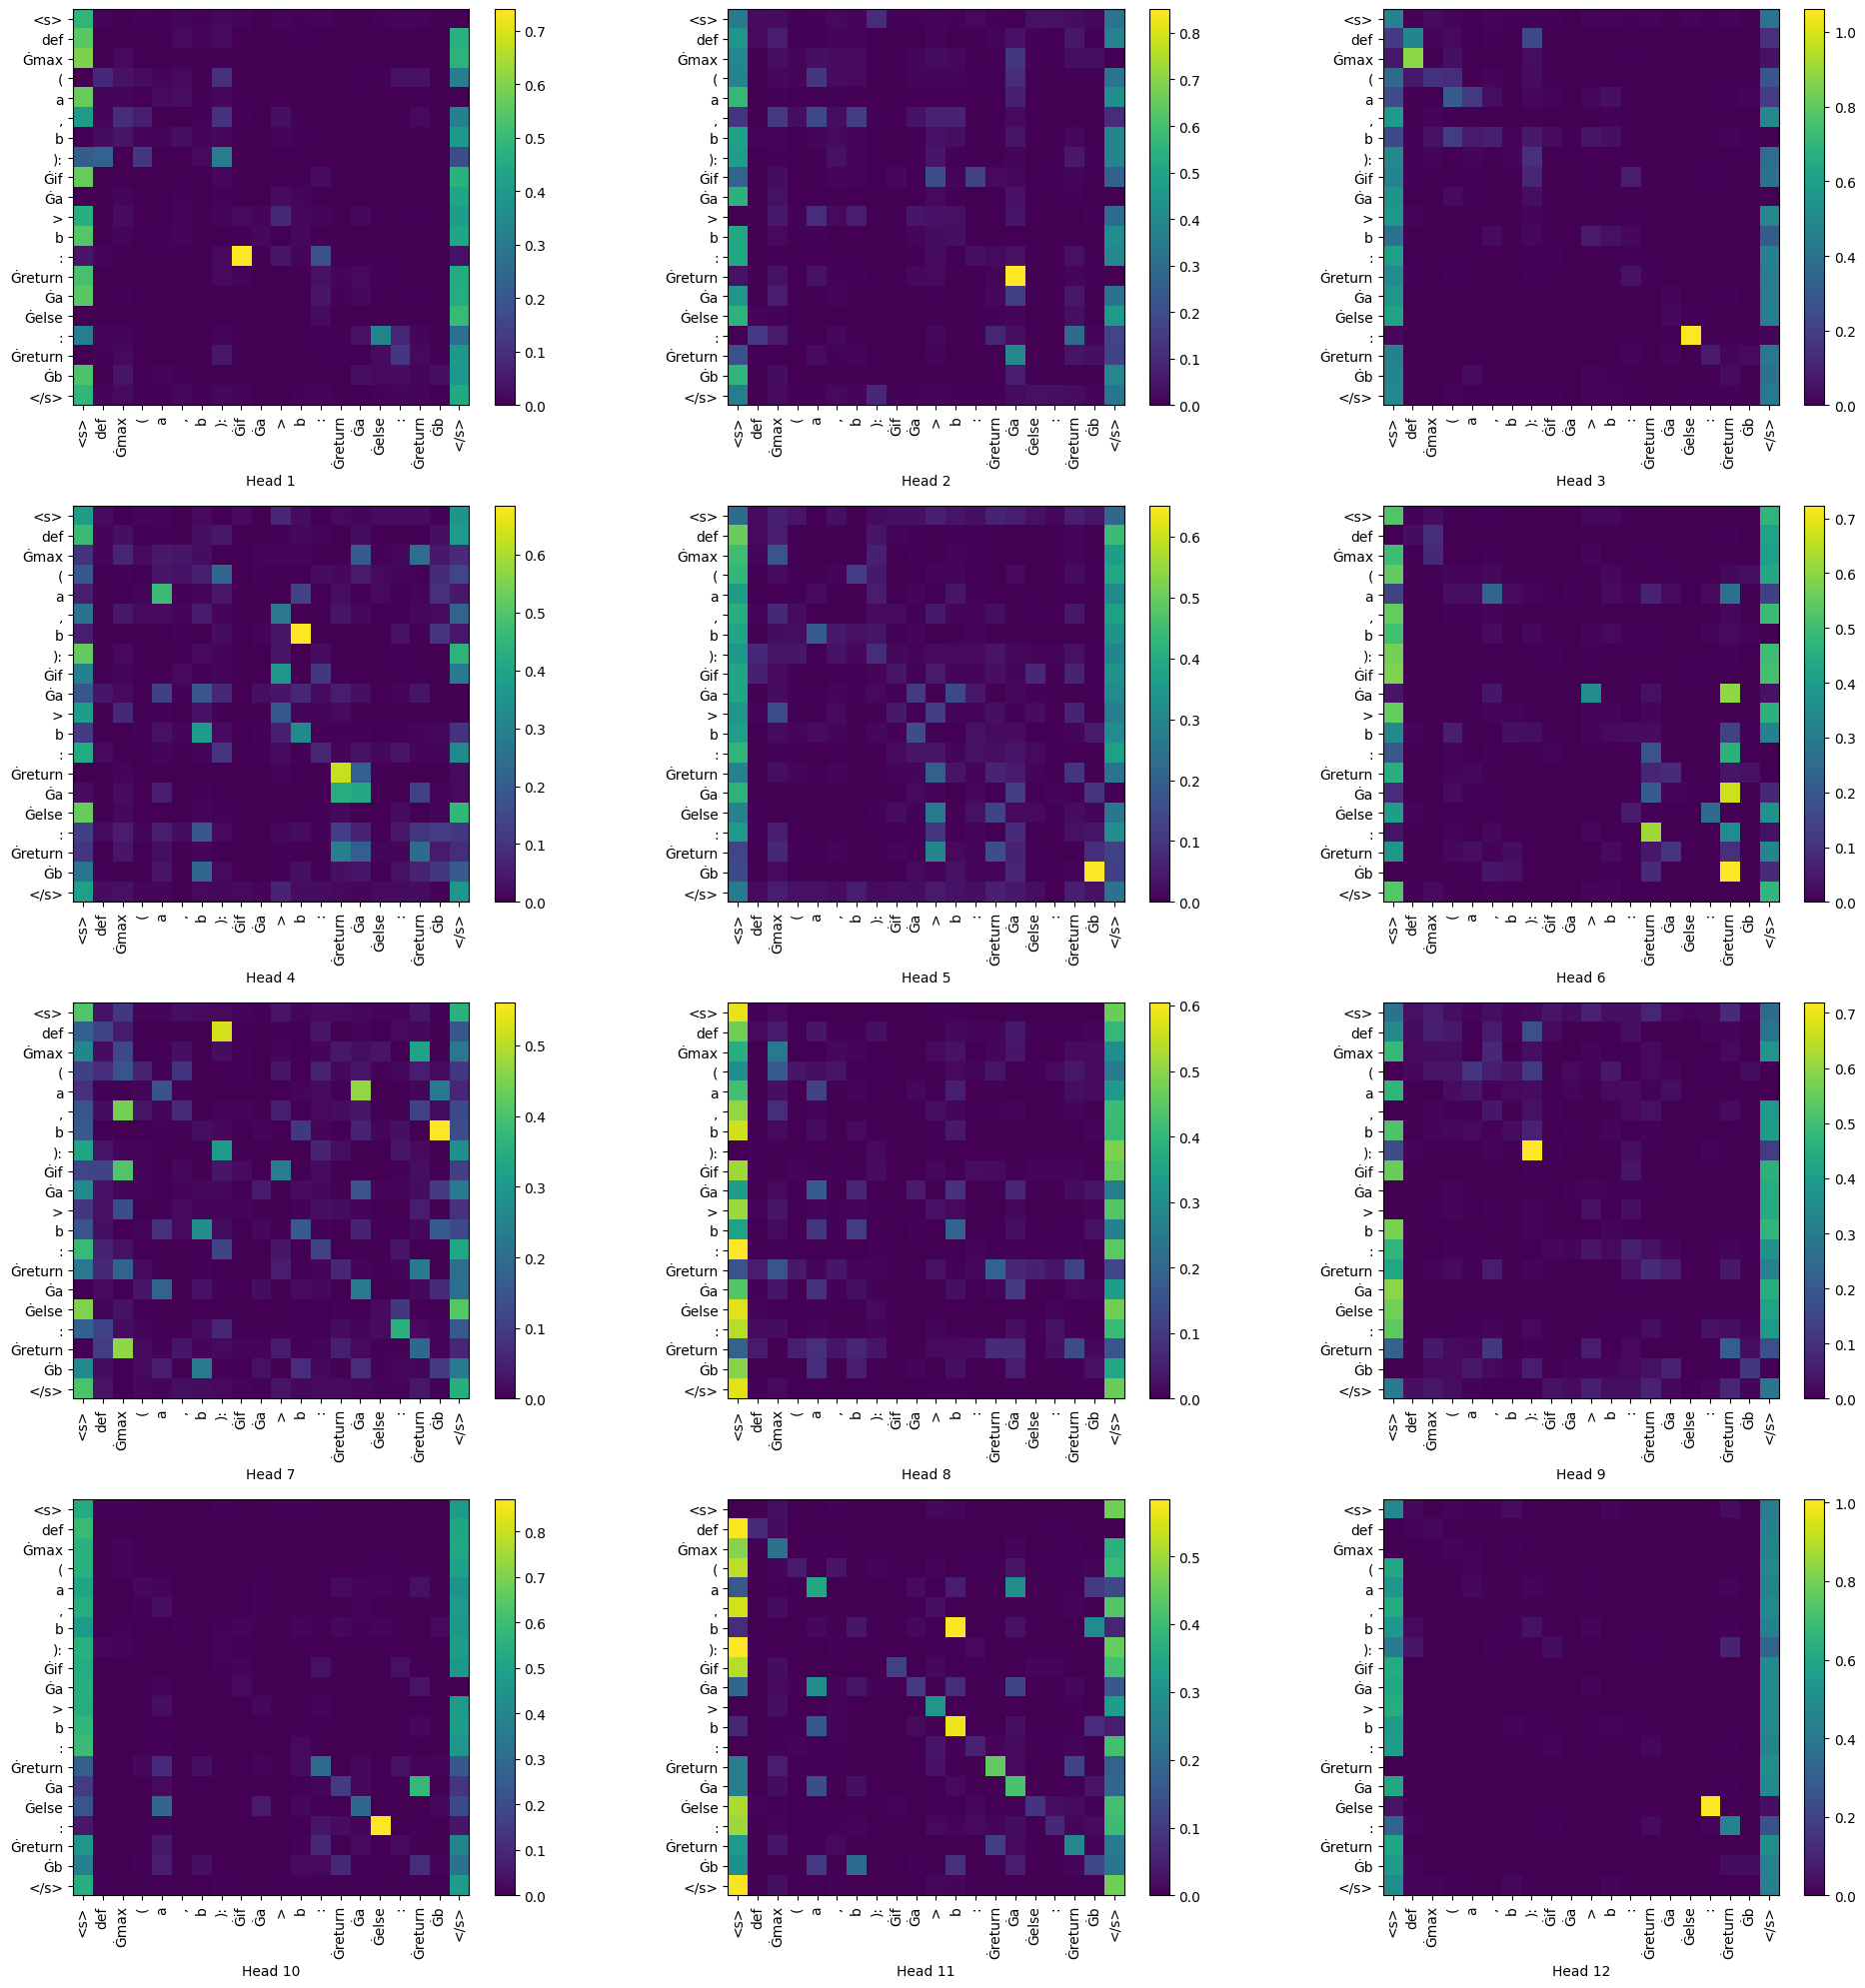

In [27]:
visualize_token2token_scores(output_attentions_all[layer].squeeze().detach().cpu().numpy())

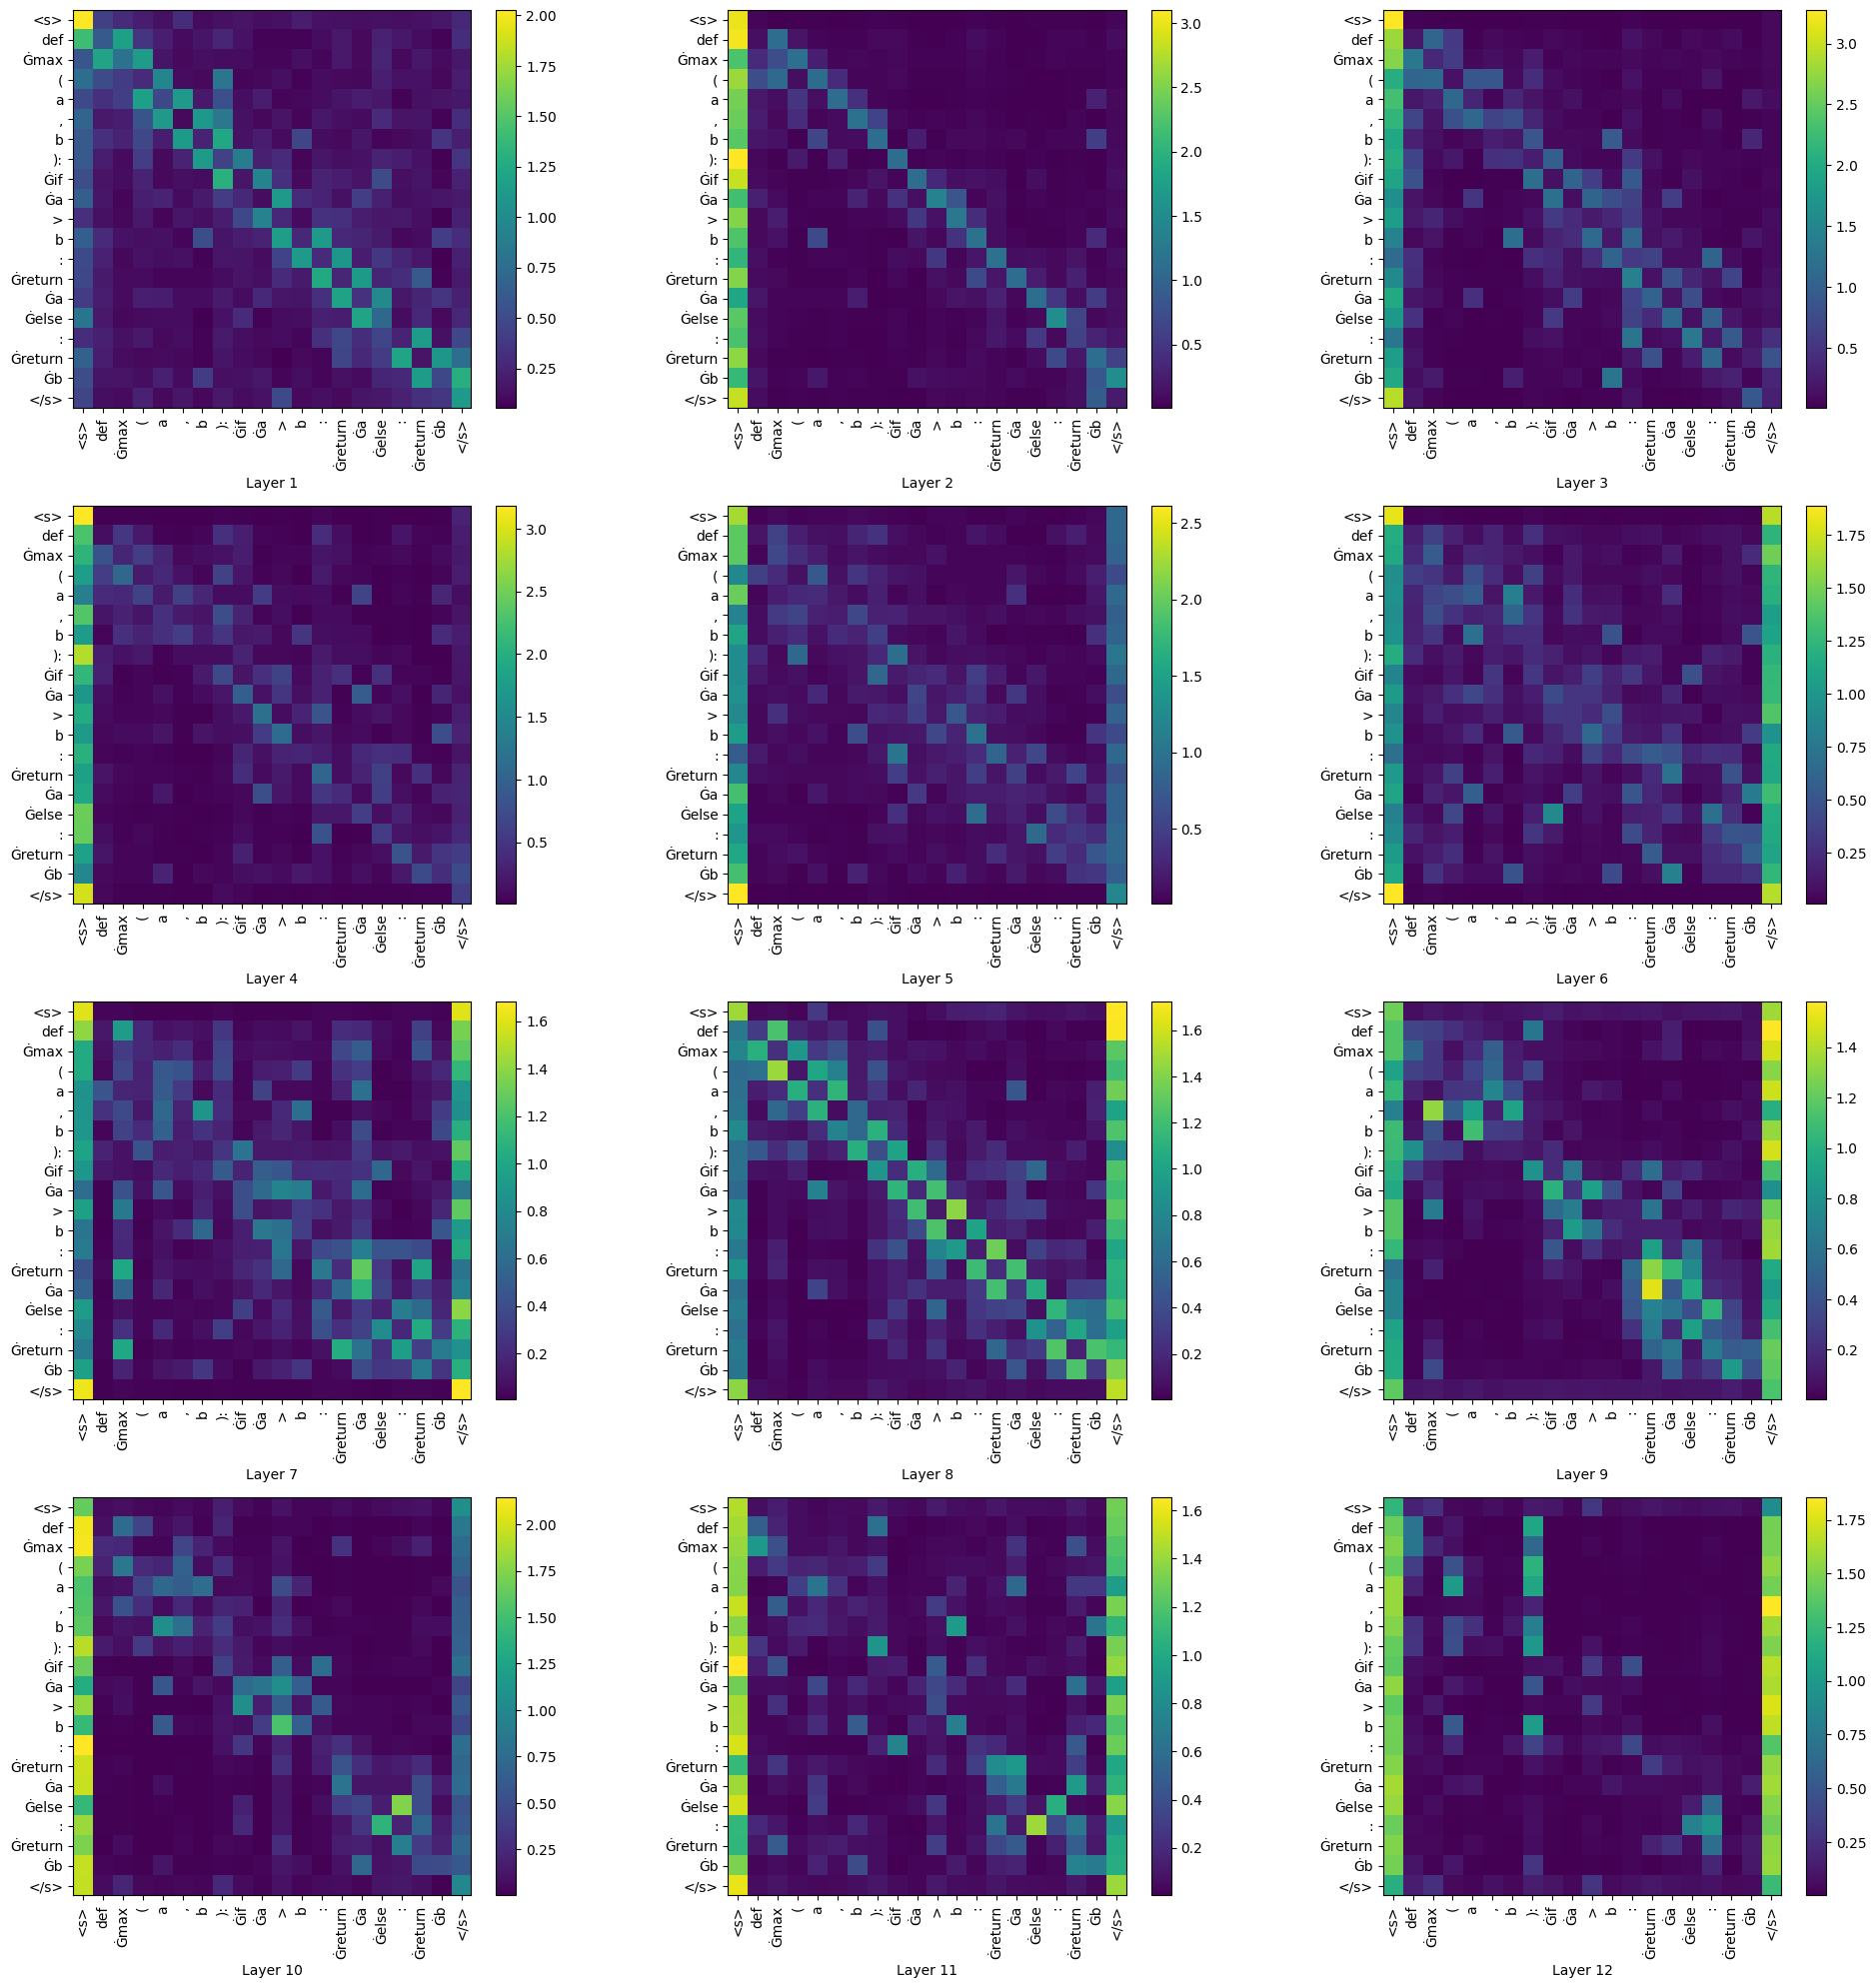

In [28]:
if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm
    
visualize_token2token_scores(norm_fn(output_attentions_all, dim=2).squeeze().detach().cpu().numpy(),
                             x_label_name='Layer')

# Visualizing attribution / importance scores

### Interpreting BertLayer Outputs and Self-Attention Matrices in each Layer

In [8]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions

In [9]:
model.encoder.roberta.embeddings.word_embeddings

Embedding(50265, 768, padding_idx=1)

In [10]:
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

interpretable_embedding = configure_interpretable_embedding_layer(model, 'encoder.roberta.embeddings.word_embeddings')

def construct_whole_bert_embeddings(input_ids, ref_input_ids):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
    
    return input_embeddings, ref_input_embeddings

/home/fjiriges/anaconda3/envs/cuBERT/lib/python3.8/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [11]:
layer_attrs = [] 

layer_attn_mat = [] 

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, reference_indices)


In [17]:
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation

lc = LayerConductance(predic_forward_func, model.encoder.roberta.encoder.layer[0])


layer_attributions = lc.attribute(inputs=input_embeddings, 
                                  baselines=ref_input_embeddings, 
                                  additional_forward_args=())

tensor([[0.6325],
        [0.6688],
        [0.6858],
        [0.6585],
        [0.6679],
        [0.7129],
        [0.6557],
        [0.6535],
        [0.7201],
        [0.6520],
        [0.8302],
        [0.6590],
        [0.7991],
        [0.7196],
        [0.7127],
        [0.7563],
        [0.6592],
        [0.7096],
        [0.6630],
        [0.8186],
        [0.8073],
        [0.8313],
        [0.8384],
        [0.8963],
        [0.9400],
        [0.8702],
        [0.8498],
        [0.7988],
        [0.7779],
        [0.7629],
        [0.8545],
        [0.8578],
        [0.8671],
        [0.3668],
        [0.6295],
        [0.7464],
        [0.7082],
        [0.6091],
        [0.7983],
        [0.5498],
        [0.8274],
        [0.5576],
        [0.6215],
        [0.6328],
        [0.6069],
        [0.6400],
        [0.7171],
        [0.4915],
        [0.5527],
        [0.6085],
        [0.8286]], grad_fn=<SigmoidBackward0>)
<class 'torch.Tensor'>
